# Kickstarter: Exploration & Prediction
By:
* Cen Liang
* Mahmoud Belhaj
* Jonas Cristens

### Load the required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from scikitplot.metrics import plot_confusion_matrix
from scikitplot.estimators import plot_feature_importances
from scikitplot.estimators import plot_learning_curve
from scikitplot.cluster import plot_elbow_curve
from scikitplot.metrics import plot_silhouette
from scikitplot.decomposition import plot_pca_component_variance
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.neural_network import MLPClassifier
from scipy import stats
import textstat

from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

### Read the Kickstarter projects file 201801 csv and parse the dates and change the categorical columns to categories

In [2]:
df = pd.read_csv('ks-projects-201801.csv', parse_dates = ['launched', 'deadline'], index_col = 'ID')
df = df.astype({"category": 'category',
                "main_category": 'category', 
                "currency": 'category', 
                'state' : 'category', 
                'country' : 'category',
               })
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### Check if there is data missing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 1000002330 to 999988282
Data columns (total 14 columns):
name                378657 non-null object
category            378661 non-null category
main_category       378661 non-null category
currency            378661 non-null category
deadline            378661 non-null datetime64[ns]
goal                378661 non-null float64
launched            378661 non-null datetime64[ns]
pledged             378661 non-null float64
state               378661 non-null category
backers             378661 non-null int64
country             378661 non-null category
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: category(5), datetime64[ns](2), float64(5), int64(1), object(1)
memory usage: 31.1+ MB


There are 3797 missing values for the column `usd_plegded` and 4 missing for the column `name`, there in total 378661 rows and 16 columns. 

`usd_plegded` is a conversion made by KS which sometime is the `usd_pledged_real` or sometimes a calculation which we don't understand.

In [4]:
df.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


The standard deviation in GOAL, pledged, usd_pledged, usd_pledged_real and usd_goal_real is high. This indicates
that the data is spread out.

### Check the data types

In [5]:
df.dtypes

name                        object
category                  category
main_category             category
currency                  category
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                     category
backers                      int64
country                   category
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

The dtypes are correct now we can calculate the difference in days between `launced` and `deadline`.

### Number of words and characters in name

Calculate the lenght of the name of the Kickstarter project.

In [6]:
df['number_of_chars'] = df['name'].str.len()

Split the name of the Kickstarter project based on a space and count how many splits there are.

In [7]:
df['number_of_words'] = df['name'].apply(lambda x: len(str(x).split()))

### Syllable count

In [8]:
df["syllable_count"] = df["name"].apply(lambda x: textstat.syllable_count(str(x)))

### Launched dates

Calculate the number of week when the campaign was launched.

In [9]:
df["launched_week"] = df["launched"].dt.week

In [10]:
df["launched_month"] = df["launched"].dt.month

df["launched_day"] = df["launched"].dt.weekday

### Days to collect

Calculate the number of days difference between the deadline and launch date.

In [11]:
df['days_to_collect'] = (df['deadline'] - df['launched']).dt.days
df['days_to_collect'].head(5)

ID
1000002330    58
1000003930    59
1000004038    44
1000007540    29
1000011046    55
Name: days_to_collect, dtype: int64

### Average amount per day needed to reach the goal

In [12]:
# replace the inf values with 0 (0/something) = np.inf) 
df['usd_needed_per_day'] = (df['usd_goal_real'] / df['days_to_collect']).replace([np.inf, -np.inf], 0)

### What are the different Kickstarter states?

In [13]:
df['state'].unique()

[failed, canceled, successful, live, undefined, suspended]
Categories (6, object): [failed, canceled, successful, live, undefined, suspended]

We define 
* `failed`, `canceled`, `undefined` and `suspended` as failed.
* `successful` as success.
* `live` not relevant ==> will be deleted since our goal is to predict if it will fail or succeed

In [14]:
conditions = [df['state'].isin(['failed', 'canceled', 'undefined', 'suspended']),
             df['state'].isin(['successful'])]
df['cln_state'] = np.select(conditions, [-1, 1])

### Calculate the average contribution per backer

In [15]:
# replace the inf values with 0 (0/something) = np.inf) 
df['usd_per_backer'] = (df['usd_goal_real'] / df['backers']).replace([np.inf, -np.inf], 0)

### Average `usd_needed_per_day` per state

In [16]:
usd_pd = df.groupby('state')['usd_needed_per_day'].mean()

Text(0.5, 0, 'USD needed per day to succeed')

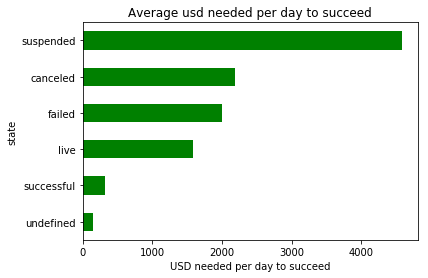

In [17]:
ax = usd_pd.sort_values().plot.barh(color='green', title='Average usd needed per day to succeed')
ax.set_xlabel('USD needed per day to succeed')

In [18]:
stats.ttest_ind(df.loc[df['state']=='successful' ,'usd_needed_per_day'].values,
                df.loc[df['state']=='canceled' ,'usd_needed_per_day'].values)

Ttest_indResult(statistic=-15.249079028640972, pvalue=1.8067227497003203e-52)

The difference between `canceled` and `successful` is significantly different for the column `usd_needed_per_day`. So the `usd_needed_per_day` really makes a different.

### Does the length of the project make a difference (0 - 30 days and 31 - 60 days)

In [19]:
# add 2 bins ranging from 0 - 30 (short) and 31 - 60 (long)
df['days_bins'] = pd.cut(df['days_to_collect'], 
                         bins = [0,30,60], 
                         labels=['short', 'long'])

# add 4 bins ranging from 0 - 100 (small), 101 - 500 (medium), 501 - 1000 (big), 1001 - 10000 (huge)
df['usd_bins_per_day'] = pd.cut(df['usd_needed_per_day'], 
                                bins = [0,100, 500, 1000, 10_000], 
                                labels = ['small', 'medium', 'big', 'huge'])

In [20]:
# caculate the number of occurences by 'state', 'days_bins', 'usd_bins_per_day'
length_diff = df.groupby(['state', 'days_bins', 'usd_bins_per_day'])['goal'].count()

In [21]:
# caculate the sum of occurences grouped by usd_bins_per_day for the period short
sum_count_short = length_diff[['failed', 'successful']]\
    .xs('short', level=1)\
    .reset_index()\
    .groupby('usd_bins_per_day')\
    .sum()

# caculate the sum of occurences grouped by usd_bins_per_day for the period long
sum_count_long = length_diff[['failed', 'successful']]\
    .xs('long', level=1).reset_index()\
    .groupby('usd_bins_per_day')\
    .sum()

In [22]:
# caculate the sum of successful occurences grouped by usd_bins_per_day for the period short
sum_count_short_succ = length_diff[['successful']]\
    .xs('short', level=1)\
    .reset_index()\
    .groupby('usd_bins_per_day')\
    .sum()

# caculate the sum of successful occurences grouped by usd_bins_per_day for the period long
sum_count_long_succ = length_diff[['successful']]\
    .xs('long', level=1)\
    .reset_index()\
    .groupby('usd_bins_per_day')\
    .sum()

In [23]:
# calculate the probability of being successful short term
succ_short_prob = sum_count_short_succ / sum_count_short
# calculate the probability of being successful long term
succ_long_prob = sum_count_long_succ / sum_count_long

In [24]:
# rename the columns to short and long
succ_short_prob = succ_short_prob.rename(columns = {'goal':'short'})
succ_long_prob = succ_long_prob.rename(columns = {'goal':'long'})

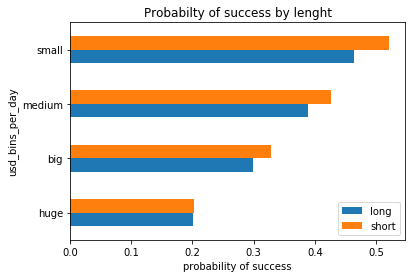

In [25]:
# plot the probability of being successful for short and long term per usd_bins_per_day
ax = pd.concat([succ_long_prob, succ_short_prob], axis=1)\
    .sort_values(by='short')\
    .plot\
    .barh(title = 'Probabilty of success by lenght')

ax.set_xlabel('probability of success');

### Check the probability of success per `main_category`

In [26]:
# caculate the probability of being successful per main_category
proba_state_main = df.groupby(['main_category', 'state'])['launched'].count()\
    / \
    df.groupby('main_category')['launched'].count()

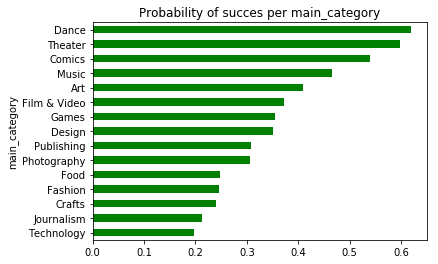

In [27]:
proba_state_main.xs('successful', level=1)\
    .sort_values(ascending=True)\
    .plot\
    .barh(color='green', title='Probability of succes per main_category');

### Top 5 most successful projects (the onces with most USD money pledged)

In [28]:
df.loc[df['state'] == 'successful'].sort_values(by='usd_pledged_real', ascending=False).iloc[:5]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,...,syllable_count,launched_week,launched_month,launched_day,days_to_collect,usd_needed_per_day,cln_state,usd_per_backer,days_bins,usd_bins_per_day
ID,,,,,,,,,,,,,,,,,,,,,
1799979574,"Pebble Time - Awesome Smartwatch, No Compromises",Product Design,Design,USD,2015-03-28,500000.0,2015-02-24 15:44:42,20338986.27,successful,78471,...,13,9,2,1,31,16129.032258,1,6.371781,long,NaN
342886736,COOLEST COOLER: 21st Century Cooler that's Act...,Product Design,Design,USD,2014-08-30,50000.0,2014-07-08 10:14:37,13285226.36,successful,62642,...,16,28,7,1,52,961.538462,1,0.798187,long,big
2103598555,"Pebble 2, Time 2 + All-New Pebble Core",Product Design,Design,USD,2016-06-30,1000000.0,2016-05-24 15:49:52,12779843.49,successful,66673,...,11,21,5,1,36,27777.777778,1,14.998575,long,NaN
545070200,Kingdom Death: Monster 1.5,Tabletop Games,Games,USD,2017-01-08,100000.0,2016-11-25 06:01:41,12393139.69,successful,19264,...,6,47,11,4,43,2325.581395,1,5.191030,long,huge
506924864,Pebble: E-Paper Watch for iPhone and Android,Product Design,Design,USD,2012-05-19,100000.0,2012-04-11 06:59:04,10266845.74,successful,68929,...,10,15,4,2,37,2702.702703,1,1.450768,long,huge


### Top 5 most successful where `goal > 100` projects (the onces with the highest ratio `usd_pledged_real` / `goal`)

In [29]:
df['goal_ratio'] = df['usd_pledged_real'] / df['goal']

In [30]:
df.loc[(df['state'] == 'successful') & (df['goal']>100)]\
    .sort_values(
        by='goal_ratio', 
        ascending=False)\
    .iloc[:5]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,...,launched_week,launched_month,launched_day,days_to_collect,usd_needed_per_day,cln_state,usd_per_backer,days_bins,usd_bins_per_day,goal_ratio
ID,,,,,,,,,,,,,,,,,,,,,
1176482851,TREVOR HALL presents... The Fruitful Darkness,Music,Music,USD,2017-09-06,108.0,2017-08-07 20:17:39,137570.93,successful,2254,...,32,8,0,29,3.724138,1,0.047915,short,small,1273.804907
1955357092,Exploding Kittens,Tabletop Games,Games,USD,2015-02-20,10000.0,2015-01-20 19:00:19,8782571.99,successful,219382,...,4,1,1,30,333.333333,1,0.045583,short,medium,878.257199
902047561,YOGA : TIME | The best way to practice yoga,Apps,Technology,USD,2015-03-11,108.0,2015-01-16 13:10:17,86944.00,successful,1620,...,3,1,4,53,2.037736,1,0.066667,long,small,805.037037
1538025770,MC YOGI: ONLY LOVE IS REAL,Hip-Hop,Music,USD,2014-12-20,108.0,2014-11-05 01:46:40,86506.00,successful,1440,...,45,11,2,44,2.454545,1,0.075000,long,small,800.981481
968166384,Modern Map Art Prints,Graphic Design,Design,GBP,2017-09-23,250.0,2017-08-24 01:17:10,94711.00,successful,1942,...,34,8,3,29,11.542069,1,0.172358,short,small,507.228640


### Most successful projects over 100 dollar goal  by main_category

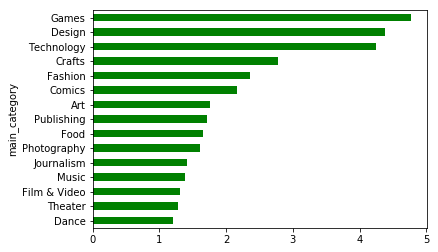

In [31]:
df[(df['state'] == 'successful') & (df['goal']>100)]\
    .groupby('main_category')['goal_ratio']\
    .mean()\
    .sort_values()\
    .plot.barh(color='green')

### Evolution of succes ratio over time

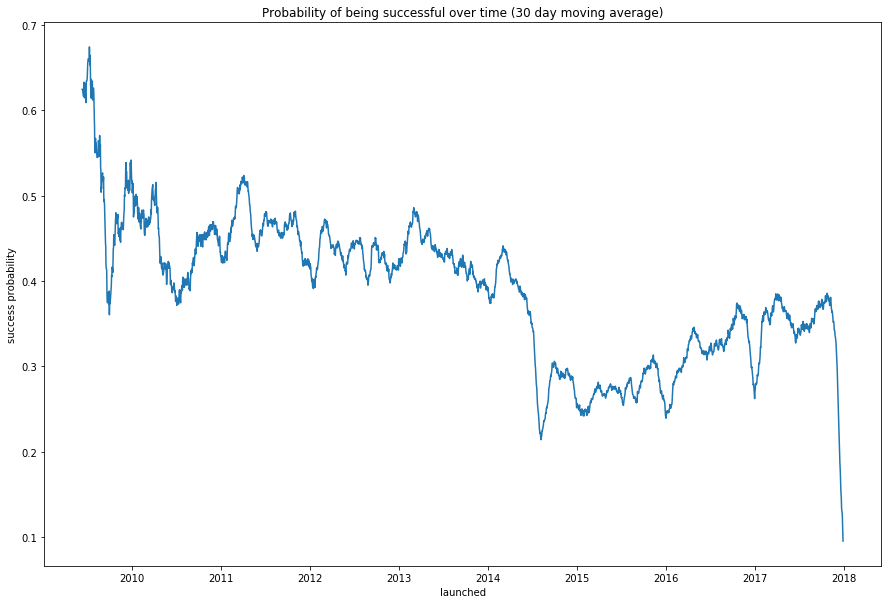

In [32]:
# caculate the number of launches per day
total_time = df.groupby([df['launched'].dt.date])['name'].count()
# caculate the number of launches per day and per state
over_time = df.groupby([df['launched'].dt.date, df['state']])['name'].count()
# caculate the probability of being successful over time
per_suc_over_time = (over_time/total_time).xs('successful', level=1)
# plot the rolling 30 day mean of the success rate
ax = per_suc_over_time.rolling(30).mean().plot(figsize = (15,10))
ax.set_ylabel('success probability')
plt.title('Probability of being successful over time (30 day moving average)');

### Plot the distribution of the numerical variables

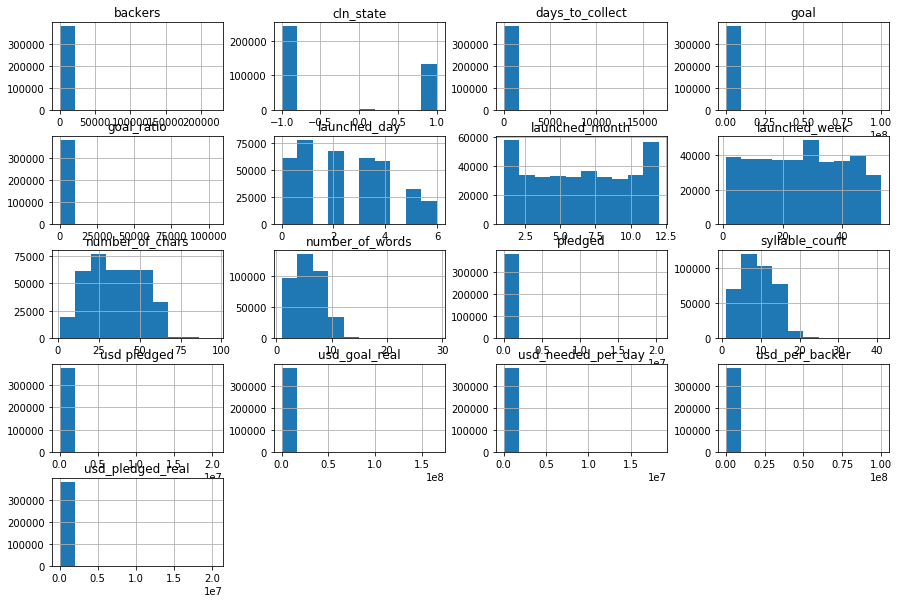

In [33]:
df.hist(figsize=(15,10));

The difference between the average and max value is huge. This means that there are serious outliers which we decided to delete (this will be done in the next step). The outliers will be removed by removing the data which is 3 or more standard deviations away from the mean.

In [34]:
cols = df.select_dtypes([np.number]).columns

In [35]:
cols = ['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real',
       'usd_goal_real']

In [36]:
df[cols] = df[cols].mask((df[cols] - df[cols].mean()).abs() > 3 * df[cols].std())
df = df.dropna()

In [37]:
# remove where cln_state = 0
df = df[df['cln_state'] !=0 ]

Now all the data which is more than 3 standard devations away from the mean is removed.

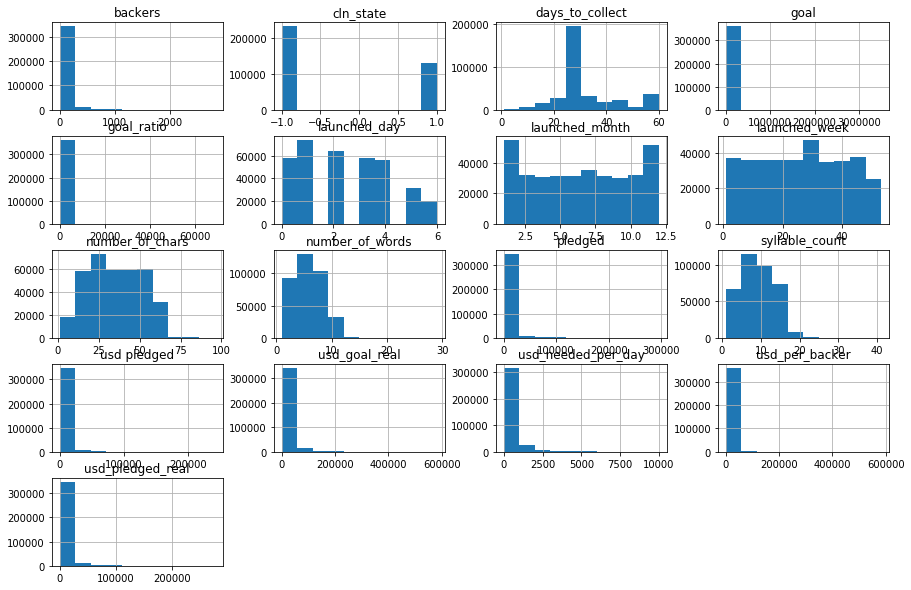

In [38]:
df.hist(figsize=(15,10));

### Diff mean category goal

In [39]:
mean_cat_goal = df.groupby('category')['goal'].sum().rename('mean_cat_goal')
mean_main_cat_goal = df.groupby('main_category')['goal'].sum().rename('mean_main_cat_goal')

In [40]:
df = df.merge(mean_cat_goal.to_frame(), how = 'left', left_on='category', right_on=mean_cat_goal.index)
df = df.merge(mean_main_cat_goal.to_frame(), how = 'left', left_on='main_category', \
              right_on=mean_main_cat_goal.index)

In [41]:
df["diff_mean_category_goal"] = df["mean_cat_goal"] - df["goal"]
df["diff_mean_main_category_goal"] = df["mean_main_cat_goal"] - df["goal"]

In [42]:
df['cln_state'].unique()

array([-1,  1])

In [43]:
df = df.drop(columns=['name', 
                      'deadline', 
                      'launched', 
                      'state', 
                      'pledged',
                      'usd pledged', 
                      'usd_pledged_real', 
                      'usd_per_backer',
                      'backers',
                      'goal_ratio'
                     ])

### Normalize the data

In [44]:
from sklearn.preprocessing import PowerTransformer

cols = df.select_dtypes([np.number]).drop(columns = 'cln_state').columns

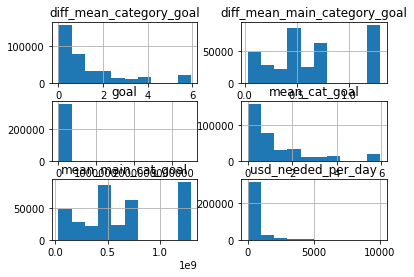

In [45]:
df[['goal', 'usd_needed_per_day'
    , 'mean_cat_goal', 'mean_main_cat_goal'\
    , 'diff_mean_category_goal', 'diff_mean_main_category_goal']].hist();

In [46]:
trans = PowerTransformer().fit_transform(X = df[['goal', 'usd_needed_per_day'\
                                                 , 'mean_cat_goal', 'mean_main_cat_goal'\
                                                 , 'diff_mean_category_goal', 'diff_mean_main_category_goal']])

In [47]:
trans_df = pd.DataFrame(trans, columns=['goal', 'usd_needed_per_day', 'mean_cat_goal', 'mean_main_cat_goal'\
                                        , 'diff_mean_category_goal', \
                                        'diff_mean_main_category_goal'], index=df.index)

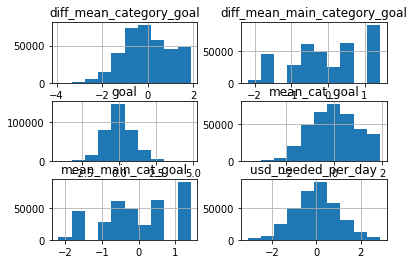

In [48]:
trans_df.hist();

### Dummies & PCA

In [49]:
months = pd.get_dummies(df['launched_month'], drop_first=True)
days = pd.get_dummies(df['launched_day'], drop_first=True)
weeks = pd.get_dummies(df['launched_week'], drop_first=True)
chars = pd.get_dummies(df['number_of_chars'], drop_first=True)
words = pd.get_dummies(df['number_of_words'], drop_first=True)
days_to_col = pd.get_dummies(df['days_to_collect'], drop_first=True)
currency = pd.get_dummies(df['currency'], drop_first=True)
main_cat = pd.get_dummies(df['main_category'], drop_first=True)
cat = pd.get_dummies(df['category'], drop_first=True)
days_bins = pd.get_dummies(df['days_bins'], drop_first=True)
usd_bins_per_day = pd.get_dummies(df['usd_bins_per_day'], drop_first=True)
syllable_count = pd.get_dummies(df['syllable_count'], drop_first=True)

In [50]:
df_dums = pd.concat([weeks, months, days, chars, words, days_to_col, currency, \
                      main_cat, cat, trans_df, syllable_count \
          , usd_bins_per_day, days_bins], axis=1)

In [51]:
X = df_dums
y = df['cln_state']

Apply oversampling because the dataset is imbalanced.

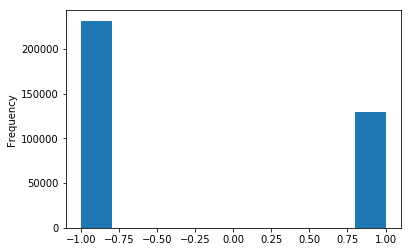

In [52]:
df['cln_state'].plot.hist()

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)

In [154]:
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

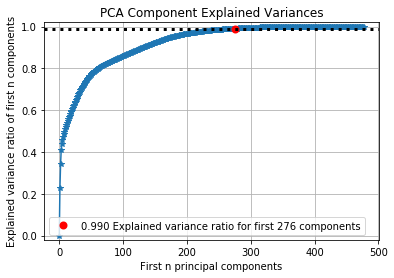

In [155]:
plot_pca_component_variance(pca, target_explained_variance=0.99)

In [156]:
pca = PCA(n_components= 0.99)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [157]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

### LogisticRegression

In [158]:
from sklearn.model_selection import cross_val_score

In [159]:
clf = LogisticRegression(C=0.01, n_jobs=-1)

In [160]:
clf.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [161]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.67 (+/- 0.00)


In [162]:
y_pred = clf.predict(X_test)

In [163]:
accuracy_score(y_test, y_pred)

0.6725792918274879

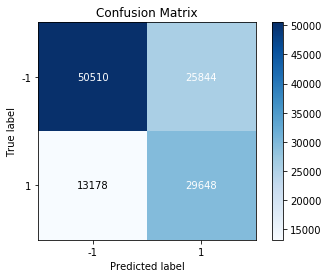

In [164]:
plot_confusion_matrix(y_test, y_pred)

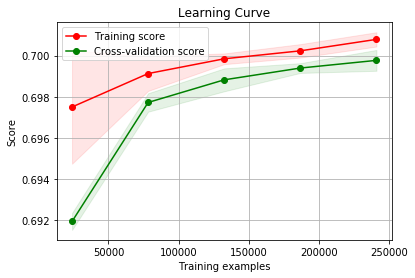

In [165]:
plot_learning_curve(clf, X, y, n_jobs=-1)

#### Grid search with logistic regression

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = {
    "C":np.logspace(-3,3,7), 
    "penalty":["l1","l2"]
}

In [ ]:
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg,grid, cv=10, n_jobs = -1)
logreg_cv.fit(X_train, y_train)

In [70]:
print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
accuracy : 0.6697056828094208


### KMeans

In [68]:
cls = KMeans(n_clusters=2)

In [69]:
clusters = cls.fit(X_train)

In [71]:
X_train = np.concatenate((X_train, np.expand_dims(cls.predict(X_train), axis =1)), axis=1)
X_test = np.concatenate((X_test, np.expand_dims(cls.predict(X_test), axis =1)), axis=1)

### ExtraTreeClassifier

In [166]:
clf = ExtraTreesClassifier(min_samples_split=200, max_depth=30,  n_jobs=-1)
clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=30, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=200,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [167]:
y_pred = clf.predict(X_test)

In [168]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.69 (+/- 0.02)


In [169]:
accuracy_score(y_test, y_pred)

0.6685685517704313

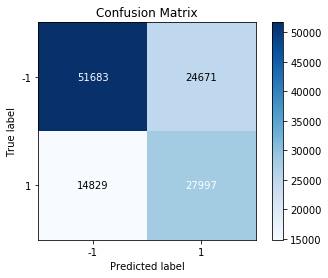

In [170]:
plot_confusion_matrix(y_test, y_pred)

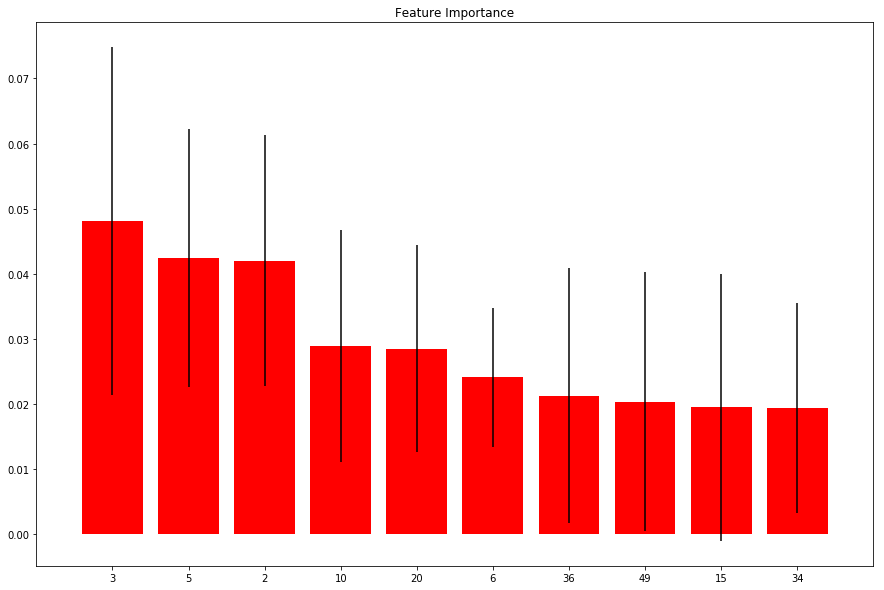

In [171]:
fig, ax = plt.subplots(figsize=(15,10))
plot_feature_importances(clf, feature_names=X.columns.values, max_num_features=10, ax=ax)

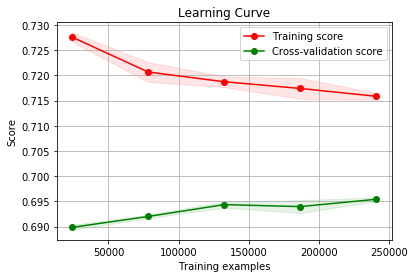

In [172]:
plot_learning_curve(clf, X, y, n_jobs=-1)

### GradientBoostingClassifier

In [543]:
from sklearn.ensemble import GradientBoostingClassifier

In [544]:
clf = GradientBoostingClassifier()

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
plot_learning_curve(clf, X, y, n_jobs=-1)

### XGBoost

In [90]:
import xgboost as xgb

In [92]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
plot_learning_curve(xgb_model, X, y, n_jobs=-1)

## Bad results

### SGDClassifier

In [173]:
from sklearn.linear_model import SGDClassifier

In [174]:
clf = SGDClassifier(n_jobs=-1)

In [175]:
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [176]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.67 (+/- 0.00)


In [177]:
y_pred = clf.predict(X_test)

In [178]:
accuracy_score(y_test, y_pred)

0.6643396543044134

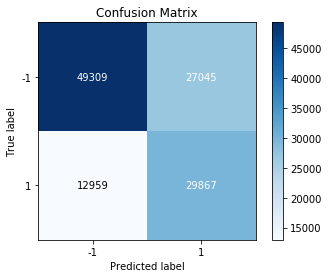

In [179]:
plot_confusion_matrix(y_test, y_pred)

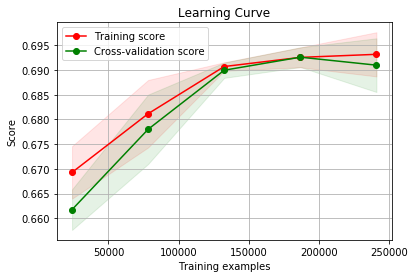

In [180]:
plot_learning_curve(clf, X, y, n_jobs=-1)

In [ ]:
grid = {
    "loss":['hinge'], 
    "penalty":["l2"],
    'alpha': np.logspace(-6,-3,7)
}

clf = SGDClassifier(n_jobs=-1)
logreg_cv = GridSearchCV(clf,grid, cv=3, n_jobs = -1)
logreg_cv.fit(X_train, y_train)

In [ ]:
print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

### RBFSampler

In [75]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

In [81]:
rbf_feature = RBFSampler(gamma=0.001, n_components=1000, random_state=1)
X_features = rbf_feature.fit_transform(X_train)
clf = SGDClassifier()
clf.fit(X_features, y_train)   

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [82]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.65 (+/- 0.01)


In [83]:
X_features_t = rbf_feature.fit_transform(X_test)
y_pred = clf.predict(X_features_t)

In [84]:
accuracy_score(y_test, y_pred)

0.6200369189461319

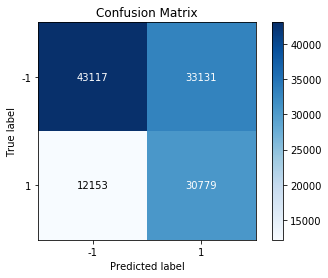

In [85]:
plot_confusion_matrix(y_test, y_pred)

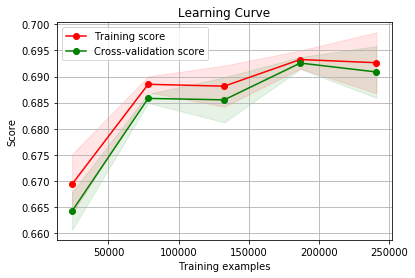

In [86]:
plot_learning_curve(clf, X, y, n_jobs=-1)

#### RBFSampler gridsearch

In [120]:
from sklearn.pipeline import Pipeline

In [134]:
grid = {
    "rbfsampler__n_components": np.linspace(188,1000,5, dtype=int),
    'rbfsampler__gamma': np.logspace(-3,3,5)
}

In [136]:
rbf_feature = RBFSampler(random_state=1)
clf = SGDClassifier(alpha = 0.001, loss = 'hinge', penalty = 'l2')

rbf_clf = Pipeline(steps=[('rbfsampler', rbf_feature), ('sgd', clf)])  

logreg_cv = GridSearchCV(rbf_clf, grid, cv=3, n_jobs = -1)
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('rbfsampler', RBFSampler(gamma=1.0, n_components=100, random_state=1)), ('sgd', SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optim..._state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'rbfsampler__n_components': array([ 188,  391,  594,  797, 1000]), 'rbfsampler__gamma': array([1.00000e-03, 3.16228e-02, 1.00000e+00, 3.16228e+01, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [137]:
print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'rbfsampler__gamma': 0.03162277660168379, 'rbfsampler__n_components': 1000}
accuracy : 0.6504894517494265


### Neural Network

In [62]:
clf = MLPClassifier(hidden_layer_sizes=(189,2), learning_rate='invscaling', warm_start=True)

In [63]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(189, 2), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)

In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [66]:
y_pred = clf.predict(X_test)

In [67]:
accuracy_score(y_test, y_pred)

0.6409602880191115

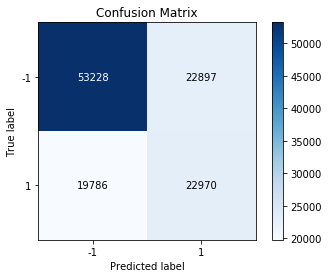

In [68]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
plot_learning_curve(clf, X, y, n_jobs=-1)